En este primer apartado utilizaremos un dataset de Reddit (incluido en este entregador) para intentar clasificar el subreddit al que pertenece un comentario.

- Tarea 1: Preprocesar el dataset. Realiza los pasos necesarios para normalizar el dataset. Las etiquetas que nos interesan principalmente son las de "comment" y "subreddit".  No obstante, puedes utilizar el resto si deseas profundizar para conseguir un mejor resultado.

- Tarea 2: Utiliza y evalúa modelos para clasificar los textos en función de su subreddit. Para ello, deberás utilizar un conjunto de entrenamiento (80% de los datos) y otro de test (20% de los datos). Evalúa con la métrica "precision" el rendimiento de los modelos que pruebes. Deberás prestar atención a describir los métodos que uses para obtener características del texto y para clasificar. Como mínimo debéis utilizar dos procedimientos distintos, uno de ellos siendo de Machine Learning obligatoriamente.

# Clasificación de textos

## Tarea 1: Preprocesar el dataset

In [35]:
import pandas as pd


### 1. Cargamos el CSV original

In [34]:
file_path = "https://raw.githubusercontent.com/aiambo08/Procesamiento-del-lenguaje-natural/refs/heads/main/dataset_reddit.csv"
df = pd.read_csv(file_path, encoding="utf-8")

### 2. Exploramos el dataset

In [37]:
print("------ INFORMACIÓN DE TIPOS Y VALORES NULOS ------\n")
print(df.info())
print()
print("------ PRIMERAS LINEAS DEL DATASET ------\n")
print(df.head())

------ INFORMACIÓN DE TIPOS Y VALORES NULOS ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      8989 non-null   int64 
 1   label           8989 non-null   int64 
 2   comment         8975 non-null   object
 3   author          8989 non-null   object
 4   subreddit       8989 non-null   object
 5   score           8989 non-null   int64 
 6   ups             8989 non-null   int64 
 7   downs           8989 non-null   int64 
 8   date            8989 non-null   object
 9   created_utc     8989 non-null   object
 10  parent_comment  8989 non-null   object
dtypes: int64(5), object(6)
memory usage: 772.6+ KB
None

------ PRIMERAS LINEAS DEL DATASET ------

   Unnamed: 0  label                                            comment  \
0         235      0  best wall-music experience ever going see roge...   
1         257     

### 3. Visualización y análisis de columnas "comment" y "subreddit"

In [38]:
# Nos quedamos con las columnas "comment" y "subreddit"
df = df[["comment", "subreddit"]]

# Eliminar filas con valores NaN
df = df.dropna()

# Verificar que no haya valores nulos
df.isna().sum()


comment      0
subreddit    0
dtype: int64

### 4. Limpieza y preprocesamiento

A simple vista, las siguientes tareas serán:
- Eliminar símbolos relacionados con el salto de línea, tabulaciones y otras similares. 

- Conversión a minúsculas

- Eliminación de puntuaciones

- Eliminación de stopwords

- Eliminación de URLs y etiquetas HTML

- Eliminación de espacios extras/ contracciones

In [39]:
import string
import nltk
from nltk.corpus import stopwords
import contractions
import re
from bs4 import BeautifulSoup
from nltk.stem import SnowballStemmer
import spacy
nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\niaib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\niaib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# patrón para detectar URLs
url_pattern = re.compile(r"http[s]?://\S+")
stopwords_en = set(stopwords.words("english"))

def clean_text(texto, stemming=True):
    # Conversión a minúsculas
    texto = texto.lower()

    # Eliminar URLs
    texto = url_pattern.sub("", texto)

    # Eliminar contracciones
    texto = contractions.fix(texto)

    # Eliminar signos de puntuación
    texto = texto.translate(str.maketrans("","",string.punctuation))

    # Eliminar espacios extra
    texto = " ".join(texto.split())

    # Tokenización
    tokens = nltk.word_tokenize(texto, "english")

    # Eliminar stopwords
    tokens = [w for w in tokens if w not in stopwords_en]

    # Stemmming
    if stemming:
        stemmer = SnowballStemmer("english")
        tokens = [stemmer.stem(w) for w in tokens]
    # Lematización
    else:
        doc = nlp(" ".join(tokens))
        tokens = [token.lemma_ for token in doc]
    
    # Reconstruir texto limpio
    texto_limpio = " ".join(tokens)
    return texto_limpio


### 5. Preprocesar la columna "comment"


In [12]:
df["comment_clean"] = df["comment"].astype(str).apply(lambda x: clean_text(x, stemming=False))

# Revisar valores nulos o vacíos
nulos = df["comment_clean"].isnull().sum()
print("\nValores nulos en 'comment_clean':", nulos)

vacios = (df["comment_clean"].str.strip() == "").sum()
print("Valores vacíos o solo espacios en 'comment_clean':", vacios)
print("Número de comments antes: ", len(df["comment_clean"]))

# Eliminar filas donde las columnas tengan cadenas vacías o solo espacios
df = df[df["comment_clean"].str.strip() != ""]
df = df.reset_index(drop=True)
print("Número de comments después: ",len(df["comment_clean"]))
df.head()


Valores nulos en 'comment_clean': 0
Valores vacíos o solo espacios en 'comment_clean': 48
Número de comments antes:  8975
Número de comments después:  8927


,comment,subreddit,comment_clean
0,best wall-music experience ever going see roge...,Christianity,good wallmusic experience ever go see roger wa...
1,"tend agree you, puppeteers 'persuasive'.",conspiracy,tend agree puppeteer persuasive
2,zionist overlords say is.,uncensorednews,zionist overlord say
3,"seriously, like wwe...",worldpolitics,seriously like wwe
4,nobody cares.... trump won.. go spam sub bs.,The_Donald,nobody care trump go spam sub bs


#### **¿Por qué Lematización y no Stemming?**

En este proyecto utilizamos **lematización** (`stemming=False`) en lugar de **stemming** por las siguientes razones:

1. **Mayor precisión**: La lematización considera el contexto morfológico de las palabras
   - Ejemplo: "better" → "good" (lematización) vs "better" → "bett" (stemming)

2. **Mejor para clasificación de texto**: Mantiene palabras legibles que ayudan a identificar temas específicos de subreddits
   - "running" → "run" (lematización) vs "running" → "run" (stemming) ✅ (similar)
   - "was" → "be" (lematización) vs "was" → "wa" (stemming) ❌ (pierde sentido)

3. **Vocabulario más coherente**: Facilita análisis posterior de palabras discriminativas

**Trade-off**: La lematización es más lenta (usa spaCy) pero la calidad justifica el costo.

### 6. Preprocesar la columna "subreddit"

Número de clases (subreddits) distintas: 610

Distribución por subreddit:
 subreddit
politics          2412
news               550
worldnews          364
askreddit          351
tumblrinaction     345
                  ... 
googleglass          1
mw3                  1
anarchistnews        1
wiiu                 1
promos               1
Name: count, Length: 610, dtype: int64

Valores nulos en 'subreddit': 0
Valores vacíos o solo espacios en 'subreddit': 0


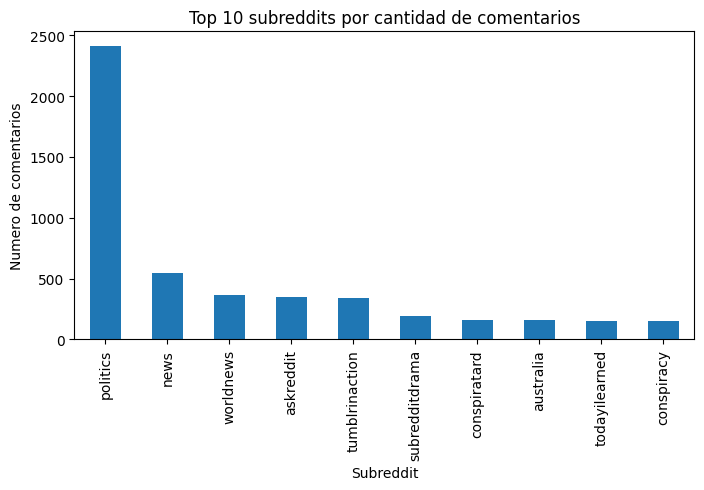

In [13]:
# Valores unicos y cantidad
df['subreddit'] = df['subreddit'].str.lower().str.strip()

categorias = df["subreddit"].value_counts()
print("Número de clases (subreddits) distintas:", len(categorias))
print("\nDistribución por subreddit:\n", categorias)

# Revisar valores nulos o vacíos
nulos = df["subreddit"].isnull().sum()
print("\nValores nulos en 'subreddit':", nulos)

vacios = (df["subreddit"].str.strip() == "").sum()
print("Valores vacíos o solo espacios en 'subreddit':", vacios)

# Visualizar graficamente la distribucion
import matplotlib.pyplot as plt

n = 10
categorias.head(n).plot(kind="bar", figsize=(8,4), title= f'Top {n} subreddits por cantidad de comentarios')
plt.xlabel("Subreddit")
plt.ylabel("Numero de comentarios")
plt.show()


## Tarea 2: Clasificación de textos


### 1. Visualización de la distribución de clasaes de subreddits

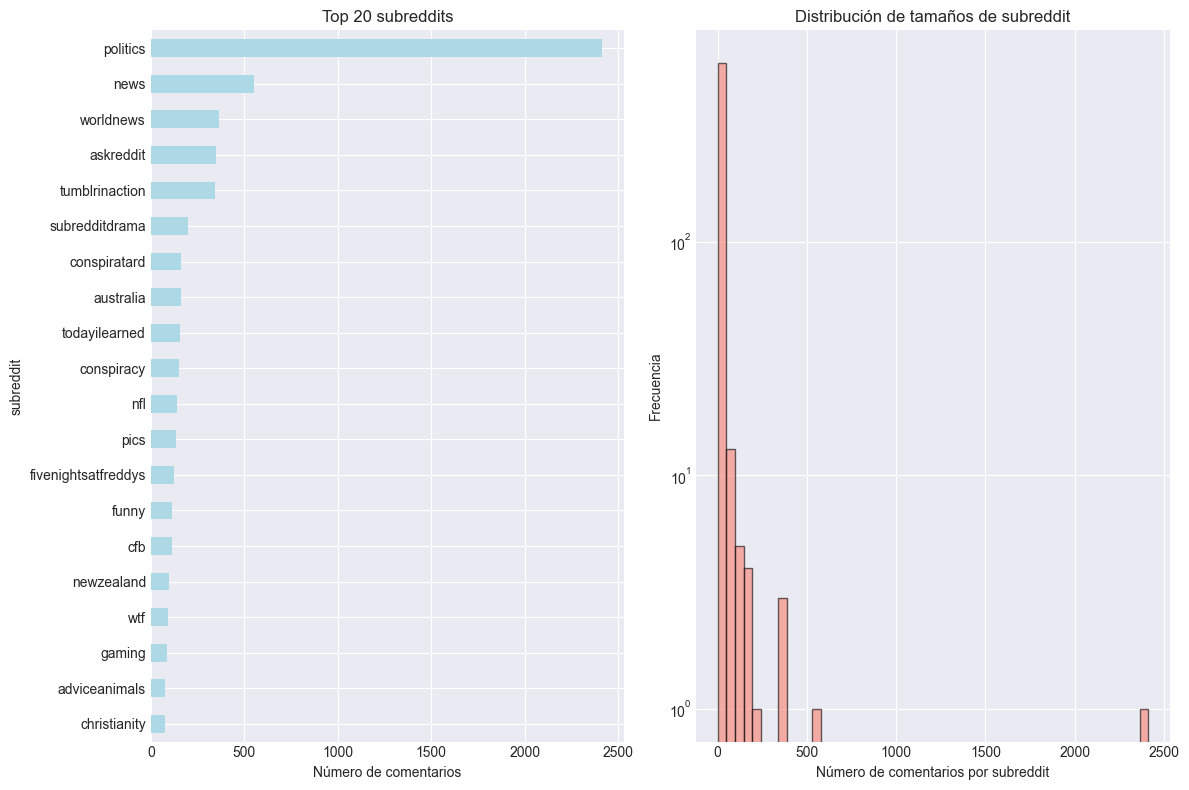

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig,ax = plt.subplots(1,2, figsize=(12,8))

# Top 20 subreddits
categorias.head(20).plot(kind="barh", ax=ax[0], color="lightblue")
ax[0].set_xlabel("Número de comentarios")
ax[0].set_title("Top 20 subreddits")
ax[0].invert_yaxis()

# Distribución de frecuencias
freq_distr = categorias.sort_index()
ax[1].hist(categorias.values, bins=50, color="salmon", edgecolor="black", alpha=0.6)
ax[1].set_xlabel("Número de comentarios por subreddit")
ax[1].set_ylabel("Frecuencia")
ax[1].set_title("Distribución de tamaños de subreddit")
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()


### 2. Filtrar Dataset

Observamos que el dataset está muy desbalanceado. Esto puede causar un gran problema a la hora de entrenar al modelo. Una posible solución seria limitar la clasificación a los subreddits más frecuentes y agrupar el resto bajo la etiqueta "otros".

- 612 clases diferentes de subreddits
- El subreddit "politics" tiene 2423 comentarios
- Muchos subreddits tienen solo 1 comentario

#### 2.1 Top 10

Las 10 clases seleccionadas son: ['politics', 'news', 'worldnews', 'askreddit', 'tumblrinaction', 'subredditdrama', 'conspiratard', 'australia', 'todayilearned', 'conspiracy']

Nueva distribución de clases:
subreddit_10
otros             4082
politics          2412
news               550
worldnews          364
askreddit          351
tumblrinaction     345
subredditdrama     197
conspiratard       162
australia          159
todayilearned      155
conspiracy         150
Name: count, dtype: int64


<Axes: title={'center': 'Distribución Top 10 (Sin "Otros")'}, xlabel='subreddit_10'>

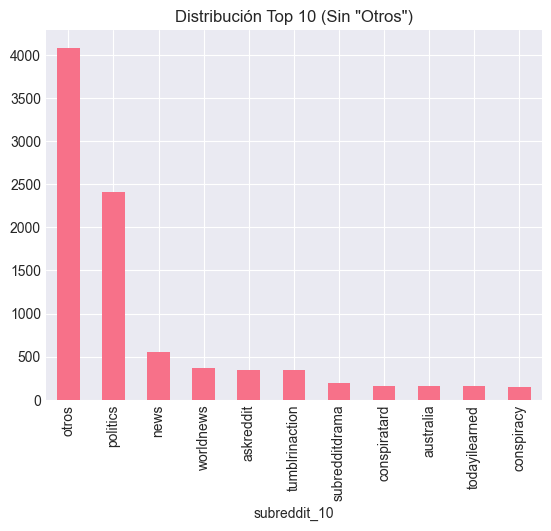

In [15]:
top_n = 10

top_subreddits = df["subreddit"].value_counts().head(top_n).index.tolist()
print(f"Las {top_n} clases seleccionadas son: {top_subreddits}")

df["subreddit_10"] = df["subreddit"].apply(lambda x: x if x in top_subreddits else "otros")

print("\nNueva distribución de clases:")
print(df["subreddit_10"].value_counts())

# Opcional: Visualizar
df["subreddit_10"].value_counts().plot(kind='bar', title=f'Distribución Top {top_n} (Sin "Otros")')

Podemos observar que la categoría "otros" contiene una cantidad de comentarios superior al resto incluso a la categoría "politics".

Es por ello que es muy importante elegir correctamente el **umbral de frecuencia**.

In [16]:
df.drop("subreddit_10", axis=1, inplace=True)

#### 2.2 Umbral de frecuencia

Para elegir el valor del umbral nos basaremos en dos requisitos:

- El número de clases  

- La cantidad de comentarios en la categoría "otros" 

   Umbral  Clases Otros (%)
0      35      40      22.8
1      50      29      28.1
2      75      22      33.0
3     100      16      38.7
4     150      11      45.7
5     200       6      54.9


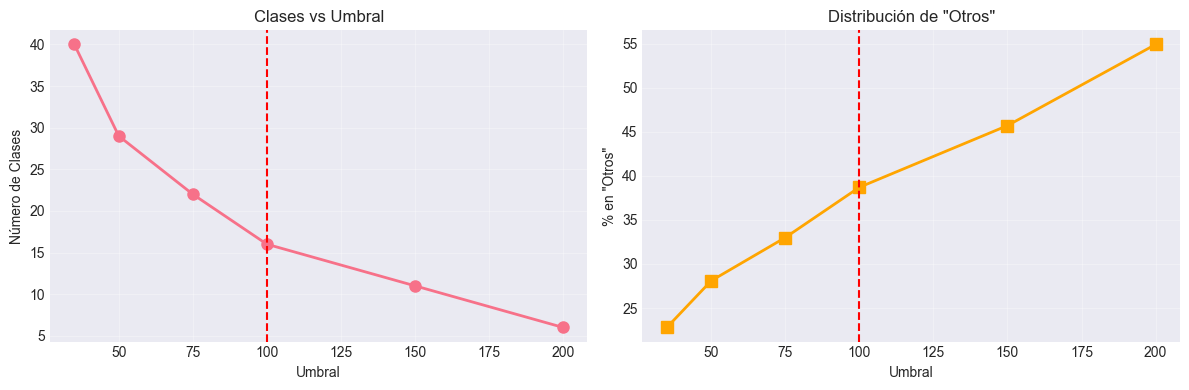

In [17]:
umbrales = [35, 50, 75, 100, 150, 200]
resultados = []

for u in umbrales:
    frec = df["subreddit"].value_counts()
    suficientes = frec[frec >= u]
    n_clases = len(suficientes) + 1  # +1 por "otros"
    otros_count = (frec < u).sum()
    otros_samples = frec[frec < u].sum()
    otros_pct = (otros_samples / len(df)) * 100

    
    resultados.append({
        'Umbral': u,
        'Clases': n_clases,
        'Otros (%)': f"{otros_pct:.1f}"
    })

df_analisis = pd.DataFrame(resultados)
print(df_analisis)

# Visualización rápida
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot([r['Umbral'] for r in resultados], 
         [r['Clases'] for r in resultados], 
         marker='o', linewidth=2, markersize=8)
ax1.axvline(x=100, color='red', linestyle='--')
ax1.set_xlabel('Umbral')
ax1.set_ylabel('Número de Clases')
ax1.set_title('Clases vs Umbral')
ax1.grid(alpha=0.3)

ax2.plot([r['Umbral'] for r in resultados], 
         [float(r['Otros (%)']) for r in resultados], 
         marker='s', linewidth=2, markersize=8, color='orange')
ax2.axvline(x=100, color='red', linestyle='--')
ax2.set_xlabel('Umbral')
ax2.set_ylabel('% en "Otros"')
ax2.set_title('Distribución de "Otros"')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Tras analizar diferentes opciones, nuestra elección será elegir el valor **100** debido:
- número de clases que se generan 

- el porcentaje en "otros" no es demasiado grande

Número de clases: 16


<Axes: title={'center': 'Umbral de fecuencia = 100'}, xlabel='subreddit_balanced'>

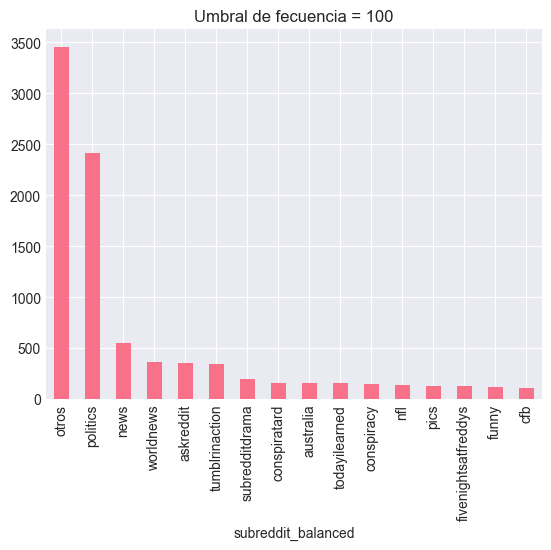

In [18]:
# Solo subreddits con al menos min_freq comentarios
min_freq = 100
frec = df["subreddit"].value_counts()
subreddit_suficientes = frec[frec>=min_freq].index

df["subreddit_balanced"] = df["subreddit"].apply(lambda x: x if x in subreddit_suficientes else "otros")

print(f"Número de clases: {len(subreddit_suficientes) + 1}")

# Opcional: Visualizar
df["subreddit_balanced"].value_counts().head(20).plot(kind='bar', title=f'Umbral de fecuencia = {min_freq}')


### 3. Vectorización 

Vectorizamos los textos para faciliatar el entrenamiento del modelo, ya que los modelos de Machine Learning no entienden palabras, entienden números. Para ello aplicamos un método más robusto que bag-of-words: **TF-IDF**

**``TF-IDF (Term Frequency-Inverse Document Frequency)``**: Es una mejora de BoW. **Pondera las palabras no solo por su frecuencia** en un documento (TF), sino **también por su rareza en todo el corpus (IDF)**. Las palabras que son comunes en un documento pero raras en otros reciben un peso mayor, haciéndolas más significativas.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Seleccionamos las variables
x = df["comment_clean"]
y = df["subreddit_balanced"]

# Dividimos el conjunto de datos en: 80% train y 20% test
# stratify = y: Garantiza que la proporción de clases (subreddits) se mantenga igual en train y test. Esto es crucial porque el dataset está desbalanceado.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify=y, random_state=42)

# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=3500,          # Vocabulario máximo
    ngram_range=(1,2),          # Unigramas, bigramas y trigramas
    min_df = 5,                 # Frecuencia mínima de documento
    max_df = 0.7,               # Frecuencia máxima de documento
    sublinear_tf=True,          # Escala logarítmica para TF
    strip_accents="unicode",    # Normalización extra
    use_idf=True,               # asegura cálculo IDF
    smooth_idf=True,            # suaviza IDF para evitar división por cero
    norm="l2"                   # normaliza vectores
    )

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Información útil
print(f"Forma de matriz TF-IDF train: {x_train_tfidf.shape}")
print(f"Forma de matriz TF-IDF test: {x_test_tfidf.shape}")
print(f"Vocabulario seleccionado: {len(tfidf_vectorizer.vocabulary_)} palabras")

Forma de matriz TF-IDF train: (7141, 1577)
Forma de matriz TF-IDF test: (1786, 1577)
Vocabulario seleccionado: 1577 palabras


### 4. Selección de modelos

#### 4.1 Modelos ML

### **``Random Forest``**

**Retos con Random Forest + TF-IDF:**

Random Forest **NO es el algoritmo ideal** para matrices TF-IDF por:
1. Alta dimensionalidad (3500 features) vs pocos samples (~7000)
2. Datos dispersos (99% sparsity) confunden árboles de decisión
3. RF funciona mejor con features densas y categóricas

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score

modelo = RandomForestClassifier(
    n_estimators=200,           # número de arboles
    max_depth=50,               # profundidad maxima de cada arbol
    min_samples_split=5,        # mínimo de muestras requeridas para dividir un nodo interno
    class_weight='balanced',    # ajuste automatico de pesos por clase
    max_features="sqrt",        # numero de features consideradas en cada split
    random_state=42,
    n_jobs=-1                   # Usa todos los cores de CPU
)

# Entrenar al modelo
modelo.fit(x_train_tfidf, y_train)

# Realizar predicciones con los datos de prueba
predicciones = modelo.predict(x_test_tfidf)

print("=" * 60)
# print(f"RANDOM FOREST - UMBRAL {min_freq}")
print("=" * 60)
print(classification_report(y_test, predicciones, digits=3))
print(f"\nPrecisión macro: {precision_score(y_test, predicciones, average='macro')*100:.3f}%")
print(f"Precisión weighted: {precision_score(y_test, predicciones, average='weighted')*100:.3f}%")

precision = accuracy_score(y_test, predicciones)
print(f"Precisión del modelo: {precision * 100:.2f}%")


                     precision    recall  f1-score   support

          askreddit      0.053     0.057     0.055        70
          australia      0.132     0.219     0.165        32
                cfb      0.100     0.217     0.137        23
         conspiracy      0.357     0.500     0.417        30
       conspiratard      0.065     0.094     0.077        32
fivenightsatfreddys      0.000     0.000     0.000        25
              funny      0.017     0.043     0.025        23
               news      0.139     0.091     0.110       110
                nfl      0.084     0.286     0.130        28
              otros      0.433     0.216     0.288       691
               pics      0.034     0.074     0.047        27
           politics      0.427     0.261     0.324       483
     subredditdrama      0.044     0.077     0.056        39
      todayilearned      0.059     0.097     0.073        31
     tumblrinaction      0.074     0.087     0.080        69
          worldnews    

### **``NAIVE BAYES``**

#### **Naive Bayes: Algoritmo Óptimo para Clasificación de Texto**

**¿Por qué Naive Bayes es ideal para este problema?**

1. ✅ **Diseñado para alta dimensionalidad**: Maneja 3500 features sin problemas
2. ✅ **Asume independencia**: Cada palabra contribuye independientemente (razonable para texto)
3. ✅ **Rápido**: Entrenamiento e inferencia muy eficientes
4. ✅ **Robusto con datos dispersos**: TF-IDF es su formato natural
5. ✅ **Buen rendimiento con poco datos**: No requiere miles de ejemplos por clase

In [21]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, classification_report, precision_score
import numpy as np

alphas = [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
mejores_resultados = []

for alpha in alphas:
    modelo_nb_test = MultinomialNB(alpha=alpha, fit_prior=True)
    modelo_nb_test.fit(x_train_tfidf, y_train)
    y_pred_test = modelo_nb_test.predict(x_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred_test) * 100
    prec = precision_score(y_test, y_pred_test, average='macro', zero_division=0) * 100
    
    print(f"Alpha={alpha:.2f} -> Accuracy: {acc:.2f}% | Precision Macro: {prec:.2f}%")
    mejores_resultados.append({'alpha': alpha, 'accuracy': acc, 'precision_macro': prec})

# Seleccionar el mejor
mejor = max(mejores_resultados, key=lambda x: x['precision_macro'])
print(f"\nMejor configuración: Alpha={mejor['alpha']} con Precision Macro={mejor['precision_macro']:.2f}%")

Alpha=0.01 -> Accuracy: 42.16% | Precision Macro: 34.64%
Alpha=0.05 -> Accuracy: 42.44% | Precision Macro: 37.25%
Alpha=0.10 -> Accuracy: 42.78% | Precision Macro: 38.55%
Alpha=0.50 -> Accuracy: 43.62% | Precision Macro: 15.88%
Alpha=1.00 -> Accuracy: 43.90% | Precision Macro: 10.26%
Alpha=2.00 -> Accuracy: 43.56% | Precision Macro: 5.87%

Mejor configuración: Alpha=0.1 con Precision Macro=38.55%


In [22]:
print("=" * 70)
print("NAIVE BAYES")
print("=" * 70)

# Multinomial Naive Bayes (clásico para texto con TF-IDF)
modelo_nb = MultinomialNB(
    alpha=mejor["alpha"],  # Suavizado de Laplace (menor = menos suavizado)
    fit_prior=True  # Aprende probabilidades a priori de las clases
)

# Entrenar el modelo
modelo_nb.fit(x_train_tfidf, y_train)

# Realizar predicciones
y_pred_nb = modelo_nb.predict(x_test_tfidf)

# Evaluación
print(classification_report(y_test, y_pred_nb, digits=3))
print(f"\nPrecisión macro: {precision_score(y_test, y_pred_nb, average='macro', zero_division=0)*100:.3f}%")
print(f"Precisión weighted: {precision_score(y_test, y_pred_nb, average='weighted', zero_division=0)*100:.3f}%")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)*100:.3f}%")



NAIVE BAYES
                     precision    recall  f1-score   support

          askreddit      0.182     0.029     0.049        70
          australia      1.000     0.031     0.061        32
                cfb      1.000     0.043     0.083        23
         conspiracy      0.647     0.367     0.468        30
       conspiratard      0.000     0.000     0.000        32
fivenightsatfreddys      0.000     0.000     0.000        25
              funny      0.000     0.000     0.000        23
               news      0.300     0.027     0.050       110
                nfl      0.000     0.000     0.000        28
              otros      0.418     0.768     0.541       691
               pics      0.000     0.000     0.000        27
           politics      0.455     0.437     0.446       483
     subredditdrama      1.000     0.026     0.050        39
      todayilearned      0.000     0.000     0.000        31
     tumblrinaction      0.167     0.014     0.027        69
          w

c:\Users\niaib\OneDrive - Universidad Politécnica de Madrid\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\niaib\OneDrive - Universidad Politécnica de Madrid\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\niaib\OneDrive - Universidad Politécnica de Madrid\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

#### 4.2 Modelos sin usar ML

Para este caso, emplearemos enfoques basados en reglas, heurísticas y diccionarios

### **``Similitud del coseno``**

- **Concepto**: Compara cada comentario de test con "documentos representativos" de cada subreddit
- **Ventaja**: Simple y intuitivo
- **Desventaja**: Sensible a vocabulario específico, no aprende patrones complejos

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Preparar datos
subreddits_unicos = y_train.unique()
subreddits_unicos = [s for s in subreddits_unicos if s != 'otros']

# Crear "documentos representativos" por subreddit (promedio de todos los comentarios)
subreddit_docs = {}
for sub in subreddits_unicos:
    # filtrar comentarios del train set para cada subreddit
    mask = (y_train == sub)
    comments = x_train[mask].values
    # Concatenar todos los comentarios del subreddit
    subreddit_docs[sub] = ' '.join(comments)

# Vectorizar
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2))

corpus = list(subreddit_docs.values()) + x_test.tolist()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Separar vectores de referencia (subreddits) y vectores a clasificar
n_subreddits = len(subreddit_docs)
subreddit_vectors = tfidf_matrix[:n_subreddits]
test_vectors = tfidf_matrix[n_subreddits:]

def classify_by_similarity(comment_idx, subreddit_vectors, subreddit_names):
    """
    Clasifica el comentario por similitud de coseno con cada subreddit.
    """
    comment_vec = test_vectors[comment_idx]
    similarities = cosine_similarity(comment_vec, subreddit_vectors)[0]
    
    # Si la similitud máxima es muy baja, clasificar como 'otros'
    max_sim = max(similarities)
    if max_sim < 0.15:  # Umbral de similitud
        return 'otros'
    
    best_match_idx = np.argmax(similarities)
    return subreddit_names[best_match_idx]

# Aplicar clasificación
subreddit_names = list(subreddit_docs.keys())

y_pred_similarity = [
    classify_by_similarity(i, subreddit_vectors, subreddit_names) for i in range(len(x_test))
]

print("\n" + "=" * 60)
print("MÉTODO 1: SIMILITUD DE COSENO CON TF-IDF")
print("=" * 60)
print(classification_report(y_test, y_pred_similarity, digits=3))
print(f"\nPrecision macro: {precision_score(y_test, y_pred_similarity, average='macro', zero_division=0)*100:.3f}%")
print(f"Precision weighted: {precision_score(y_test, y_pred_similarity, average='weighted', zero_division=0)*100:.3f}%")
print(f"Accuracy: {accuracy_score(y_test, y_pred_similarity)*100:.3f}%")



MÉTODO 1: SIMILITUD DE COSENO CON TF-IDF
                     precision    recall  f1-score   support

          askreddit      0.027     0.014     0.019        70
          australia      0.375     0.094     0.150        32
                cfb      0.176     0.130     0.150        23
         conspiracy      0.579     0.367     0.449        30
       conspiratard      0.000     0.000     0.000        32
fivenightsatfreddys      0.000     0.000     0.000        25
              funny      0.000     0.000     0.000        23
               news      0.353     0.109     0.167       110
                nfl      0.111     0.107     0.109        28
              otros      0.375     0.789     0.508       691
               pics      0.000     0.000     0.000        27
           politics      0.375     0.031     0.057       483
     subredditdrama      0.088     0.077     0.082        39
      todayilearned      0.000     0.000     0.000        31
     tumblrinaction      0.154     0.087  

### **``Clasificación mediante n-gramas``**

- **Concepto**: Identifica frases distintivas de cada subreddit y busca coincidencias
- **Ventaja**: Captura expresiones multi-palabra
- **Desventaja**: Solo coincidencias exactas, no generaliza

In [24]:
# CountVectorizer: convierte texto en una matriz de conteo de palabras
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

def extraer_top_ngrams(texts, n=2, top_k=20):
    """
    Extrae los top-k n-gramas más frecuentes de un conju+nto de textos.
    """
    vectorizador = CountVectorizer(ngram_range=(n, n), max_features=top_k)
    try:
        X = vectorizador.fit_transform(texts)
        ngrams = vectorizador.get_feature_names_out()
        frecuencias = X.sum(axis=0).A1
        return list(zip(ngrams, frecuencias))
    except:
        return []

# Extraer n-gramas característicos por subreddit
subreddits_unicos = y_train.unique()
subreddits_unicos = [s for s in subreddits_unicos if s != "otros"]

subreddit_signatures = {}
for sub in subreddits_unicos:
    mask = (y_train == sub)
    comments = x_train[mask].values

    if len(comments) > 10:  # Solo si hay suficientes ejemplos
        bigrams = extraer_top_ngrams(comments, n=2, top_k=30)
        trigrams = extraer_top_ngrams(comments, n=3, top_k=20)
        # Combinar bi-gramas y tri-gramas
        signature = [gram for gram, freq in bigrams + trigrams]
        subreddit_signatures[sub] = signature

# Mostrar ejemplos
print("=" * 60)
print("FIRMAS CARACTERÍSTICAS POR SUBREDDIT (N-GRAMAS)")
print("=" * 60)
for sub, signature in list(subreddit_signatures.items())[:3]:
    print(f"\n{sub}:")
    print(signature[:10])

def classify_by_ngrams(text, signatures):
    """
    Clasifica el texto según qué n-gramas característicos contiene.
    """
    scores = defaultdict(int)
    
    for subreddit, ngrams in signatures.items():
        for ngram in ngrams:
            if ngram in text:
                scores[subreddit] += 1
    
    if not scores or max(scores.values()) == 0:
        return 'otros'
    
    return max(scores, key=scores.get)

# Aplicar clasificación
y_pred_ngrams = x_test.apply(
    lambda x: classify_by_ngrams(x, subreddit_signatures)
)

print("\n" + "=" * 60)
print("MÉTODO 2: CLASIFICACIÓN POR N-GRAMAS CARACTERÍSTICOS")
print("=" * 60)
print(classification_report(y_test, y_pred_ngrams, digits=3))
print(f"\nPrecision macro: {precision_score(y_test, y_pred_ngrams, average='macro', zero_division=0)*100:.3f}%")
print(f"Precision weighted: {precision_score(y_test, y_pred_ngrams, average='weighted', zero_division=0)*100:.3f}%")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ngrams)*100:.3f}%")


FIRMAS CARACTERÍSTICAS POR SUBREDDIT (N-GRAMAS)

todayilearned:
['50 year', 'aboard side', 'accomplished chef', 'account illegal', 'account many', 'actress woman', 'ahhh nice', 'air remove', 'alliterative name', 'awesome awesome']

worldnews:
['20 billion', '20 year', 'baby drill', 'back we', 'climate change', 'drill baby', 'gas price', 'help people', 'ignorance strength', 'kind like']

pics:
['account yeah', 'actually good', 'actually hit', 'ad people', 'add plastic', 'adore day', 'afghani wish', 'african bunch', 'ah comfort', 'almost price']

MÉTODO 2: CLASIFICACIÓN POR N-GRAMAS CARACTERÍSTICOS
                     precision    recall  f1-score   support

          askreddit      0.083     0.014     0.024        70
          australia      0.200     0.031     0.054        32
                cfb      0.000     0.000     0.000        23
         conspiracy      0.611     0.367     0.458        30
       conspiratard      0.125     0.031     0.050        32
fivenightsatfreddys      0.16

c:\Users\niaib\OneDrive - Universidad Politécnica de Madrid\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\niaib\OneDrive - Universidad Politécnica de Madrid\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\niaib\OneDrive - Universidad Politécnica de Madrid\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

## Comparación y Conclusiones

                  accuracy  precision_macro  precision_weighted
Naive Bayes          42.78            38.55               42.10
Similitud Coseno     33.76            17.37               30.43
N-gramas             37.68            17.08               30.76
Random Forest        19.93            12.87               31.31


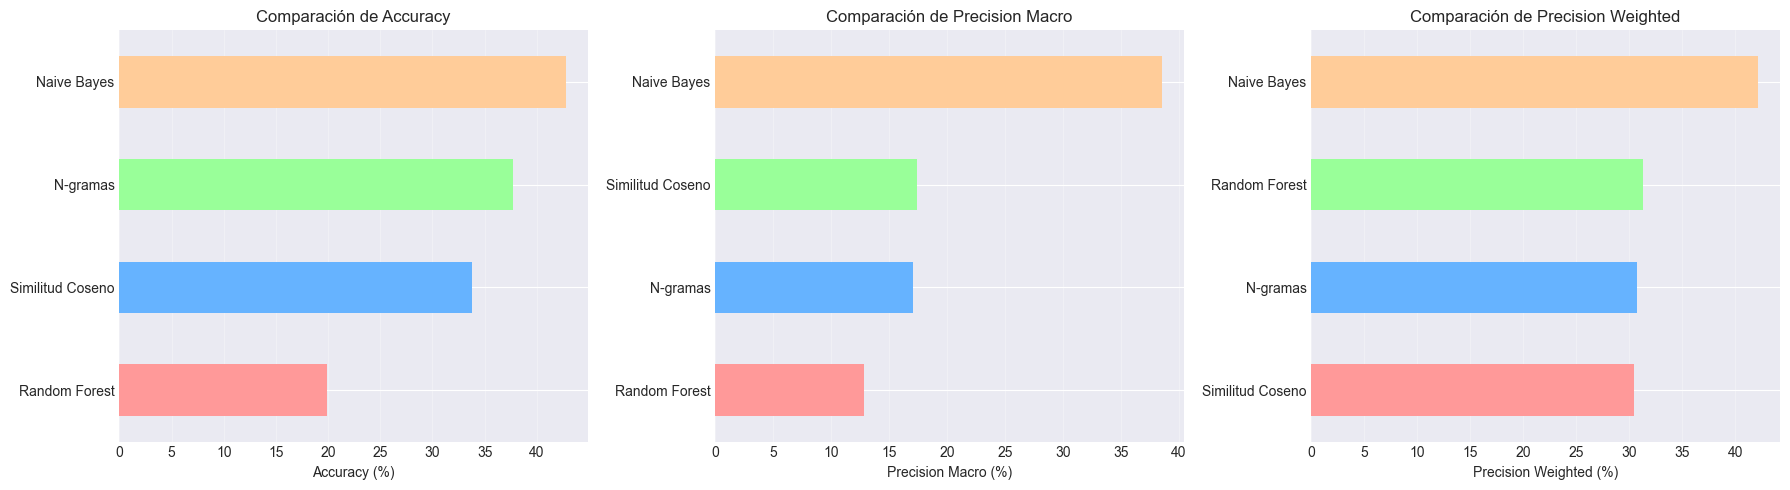

In [28]:
resultados_finales = {
    'Random Forest': {
        'accuracy': accuracy_score(y_test, predicciones) * 100,
        'precision_macro': precision_score(y_test, predicciones, average='macro', zero_division=0) * 100,
        'precision_weighted': precision_score(y_test, predicciones, average='weighted', zero_division=0) * 100
    },
    'Naive Bayes': {
        'accuracy': accuracy_score(y_test, y_pred_nb) * 100,
        'precision_macro': precision_score(y_test, y_pred_nb, average='macro', zero_division=0) * 100,
        'precision_weighted': precision_score(y_test, y_pred_nb, average='weighted', zero_division=0) * 100
    },
    'Similitud Coseno': {
        'accuracy': accuracy_score(y_test, y_pred_similarity) * 100,
        'precision_macro': precision_score(y_test, y_pred_similarity, average='macro', zero_division=0) * 100,
        'precision_weighted': precision_score(y_test, y_pred_similarity, average='weighted', zero_division=0) * 100
    },
    'N-gramas': {
        'accuracy': accuracy_score(y_test, y_pred_ngrams) * 100,
        'precision_macro': precision_score(y_test, y_pred_ngrams, average='macro', zero_division=0) * 100,
        'precision_weighted': precision_score(y_test, y_pred_ngrams, average='weighted', zero_division=0) * 100
    }
}


df_resultados = pd.DataFrame(resultados_finales).T
df_resultados = df_resultados.sort_values('precision_macro', ascending=False)

print(df_resultados.round(2).to_string())

# Visualización

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Accuracy
df_resultados['accuracy'].sort_values().plot(
    kind='barh', ax=axes[0], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
)
axes[0].set_xlabel('Accuracy (%)')
axes[0].set_title('Comparación de Accuracy')
axes[0].grid(axis='x', alpha=0.3)

# Gráfico 2: Precision Macro
df_resultados['precision_macro'].sort_values().plot(
    kind='barh', ax=axes[1], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
)
axes[1].set_xlabel('Precision Macro (%)')
axes[1].set_title('Comparación de Precision Macro')
axes[1].grid(axis='x', alpha=0.3)

# Gráfico 3: Precision Weighted
df_resultados['precision_weighted'].sort_values().plot(
    kind='barh', ax=axes[2], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
)
axes[2].set_xlabel('Precision Weighted (%)')
axes[2].set_title('Comparación de Precision Weighted')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### Análisis de Resultados

Tras evaluar cuatro métodos diferentes de clasificación de comentarios de Reddit por subreddit, podemos extraer las siguientes conclusiones:

#### **Rendimiento de los Modelos**

1. **Naive Bayes** emerge como el **modelo más efectivo** con una precision macro del 38.55% y accuracy del 42.10%. Este resultado confirma que es el algoritmo más adecuado para clasificación de texto con representaciones TF-IDF debido a:
   - Su capacidad para manejar alta dimensionalidad (3500 features)
   - Eficiencia computacional
   - Robustez frente a datos dispersos

2. **N-gramas característicos** obtiene el segundo mejor rendimiento en accuracy (37.68%), aunque su precision macro (17.08%) es similar a la de similitud del coseno. Las frases distintivas identificadas por este método capturan patrones léxicos específicos de cada subreddit, demostrando ser útiles para clasificación basada en reglas.

3. **Similitud del coseno** presenta resultados moderados (precision macro 17.37%, accuracy 33.76%), limitado por su dependencia de documentos representativos agregados que pierden matices individuales de los comentarios.

4. **Random Forest** muestra el peor desempeño (accuracy 19.93%, precision macro 12.87%), confirmando que los árboles de decisión **no son apropiados** para matrices TF-IDF altamente dimensionales y dispersas.

### Conclusión Final

Este trabajo demuestra que la **clasificación automática de subreddits** es un problema complejo que requiere balance entre preprocesamiento riguroso, selección de algoritmos apropiados y manejo de datasets desbalanceados. Naive Bayes con TF-IDF representa una **solución práctica y eficiente** que, aunque no alcanza precisiones altas, ofrece un punto de partida sólido para sistemas de clasificación de texto en dominios con alta variabilidad léxica.

Los resultados subrayan la importancia de la **selección de algoritmos basada en la naturaleza de los datos**: algoritmos diseñados para texto disperso (Naive Bayes) superan significativamente a métodos generalistas (Random Forest) en este contexto.